In [1]:
# Mount google drive and setup paths
import sys
 
# mount google drive 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
 
# specify path name to import py file
folder_name = 'Jupyter Notebooks/Quantitative Finance'
sys.path.append("drive/My Drive/" + folder_name)

Mounted at /content/drive/


In [0]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from Option import *
from Binomial_tree import *

A recombinant tree is a tree where an up-move followed by a down-move is the same as down-move followed by an up-move. 
It follows that
$$S_n = S_0 \times u^{N_u} d^{N_d}$$
where $N_u$ and $N_d$ are the number of up-move and down-move respectively.

Recombining trees are a standard method for pricing options. In this project, we try them out for some simple options.
Since a recombining tree makes use of the fact that an up-move followed by a down-move is the same as down-move followed by an up-move, this keeps the total number of node tractable; otherwise the number of nodes grows exponentially. A tree should be implemented purely in the risk-neutral world, the real-world tree is useful for justifying risk-neutral pricing but not for actually doing the pricing. We also work with the log as the geometry is simple.

To read more on binomal tree option pricing, please refer to [wikipedia](https://en.wikipedia.org/wiki/Binomial_options_pricing_model).

# Generate Binomial Price Tree
We will implement several methods to generate binomial price tree and show that they converge to the same price.

In each method, we assume that time to maturity is $T$, tree has $N$ steps of length $\Delta t = \frac{T}{N}.$

In each method, it suffices to determine the up and down multipliers $u$ and $d.$

## Cox, Ross  & Rubinstein (CRR) Tree
Cox, Ross  & Rubinstein (CRR) used up and down multipliers as
$$u = e^{\sigma\sqrt{\Delta t}} \quad \text{and} \quad d = e^{-\sigma\sqrt{\Delta t}} =\frac{1}{u}.$$
[Here](https://drive.google.com/file/d/13bBpLtKSsLzOZ-O5Cxdb4wc_fkTMYB-t/view) is a copy of the research paper of CRR.
Since $ud = du = 1,$ so CRR tree is recombinant.

## Discretize Geometric Brownian Motion (GBM) Tree
We discretize Geometric Brownian Motion's solution, that is,
$$S_{j\Delta t} = S_{(j-1)\Delta t} \exp\left[ \left( r - d - \frac{1}{2} \sigma^2 \right)\Delta t + \sigma \sqrt{\Delta t} Z_j \right] \quad \text{for all } j=1,2,...,N$$
where $Z_j$ is a Bernoulli random variable with $\mathbb{P}(Z_j = -1) = \mathbb{P}(Z_j = 1) = \frac{1}{2}.$
Therefore, 
$$u = e^{ \left( r - d - \frac{1}{2} \sigma^2 \right)\Delta t + \sigma \sqrt{\Delta t} } \quad \text{and} \quad d =e^{ \left( r - d - \frac{1}{2} \sigma^2 \right)\Delta t - \sigma \sqrt{\Delta t} }.$$
Note that 
$$ud = e^{\left( r - d - \frac{1}{2} \sigma^2 \right)2 \Delta t} \neq 1.$$

Observe that GBM tree becomes CCR tree when $r - d - \frac{1}{2}\sigma^2 = 0.$

# Pricing rules
A tree is well-suited to pricing an option whose value can be written as a function of the current spot and the option's expected value in the function.
In practical terms, we can price options whose value can be specified at a node as a function of spot at the current node, and the discounted average of the values at its two daughter nodes.
Note the discounted average will be 
$$e^{-r\Delta t} \left(\tilde{p} \text{Value-up} + (1-\tilde{p})\text{Value-down} \right)$$
where $\tilde{p}$ is the risk-neutral probability.
Work out what rule for computing the price at a node is for each of the following derivatives.

(i) a vanilla call and put option,

(ii) a forward,

(iii) a down-and-out call or put option,

(iv) an American option,

(v) a digital call and put option.


# Pricing on the tree
Now implement the binomial tree and apply it to the pricing of each of the above. If you are using an object-oriented programming langugage, keep the definitions of the tree and of the option rule as separated as possible so you can plug in various different rules without recoding the tree. The option will be specified by the rule for its value at a node, and by its final payoff.

Plot the value of each option as a function of the number of steps for reasonable parameters (e.g. spot 100, strike 100, $r = 0.05$, $\sigma = 0.1$ and $T =2$.) Check the answers you get against analytic formula or another pricing method.

For which options does the price oscillate? 
Compare the rate of convergence with that obtained by taking the sequence obtained by averaging the $N$-step oruce with the $(N+1)$-step price.

Price an option with a strike that puts the option far out-of-the-money. 
How does the speed of convergence change?


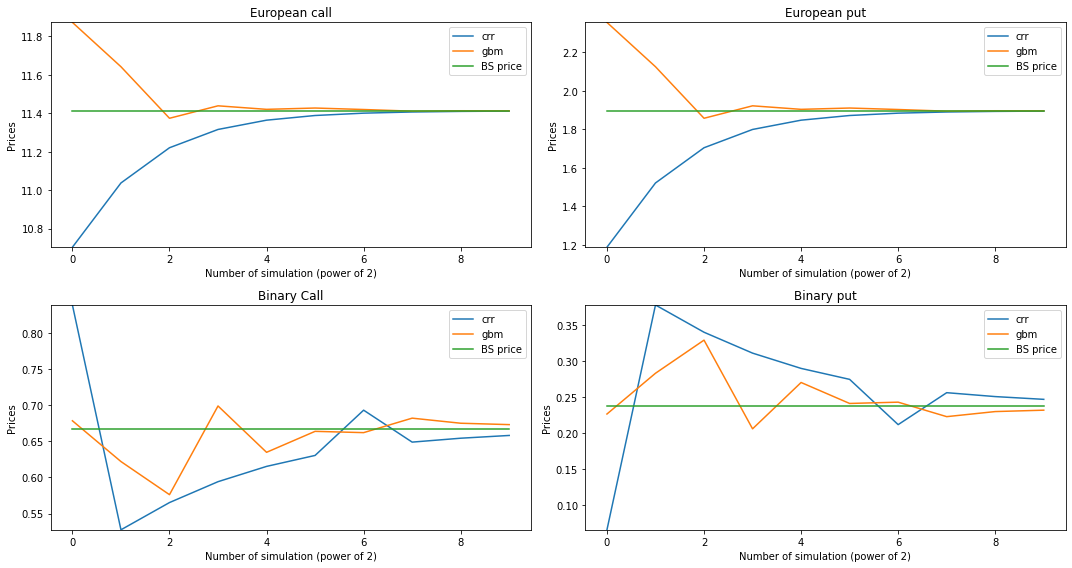

In [17]:
S0 = 100
K = 100
sigma = 0.1
r = 0.05
d = 0
T = 2

# Compare tree price by crr and gbm with Black-Scholes analytical pricing
num_sim = 10
tree = BinomialTree(S0, r, d, sigma, T)

num_rows = 2
num_cols = 2
f, ax = plt.subplots(num_rows, num_cols, figsize = (15,8))

# European and binary call and put payoff
euro_call = lambda x: np.maximum(x - K, 0)
euro_put = lambda x: np.maximum(K - x, 0)
bin_call = lambda x: np.piecewise(x, [x < K, x >= K], [0, 1])
bin_put = lambda x: np.piecewise(x, [x < K, x >= K], [1, 0])

title = ['European call', 'European put', 'Binary Call', 'Binary put']
payoffs = [euro_call, euro_put, bin_call, bin_put]
option = Option(S0, K, r, d, sigma, T)
BS_price = [option.european_call(), option.european_put(), option.binary_call(1), option.binary_put(1)]

for i, payoff in enumerate(payoffs):
  crr = tree.option_price(num_sim, payoff = payoff, model = 'crr')
  gbm = tree.option_price(num_sim, payoff = payoff, model = 'gbm')
  low = np.min(crr + gbm + [BS_price[i]])
  high = np.max(crr + gbm + [BS_price[i]])

  ax[i//num_cols, i%num_cols].plot(crr, label = 'crr')
  ax[i//num_cols, i%num_cols].plot(gbm, label = 'gbm')
  ax[i//num_cols, i%num_cols].plot([BS_price[i]] * num_sim, label = 'BS price')
  ax[i//num_cols, i%num_cols].set_ylim(low, high)
  ax[i//num_cols, i%num_cols].set_xlabel('Number of simulation (power of 2)')
  ax[i//num_cols, i%num_cols].set_ylabel('Prices')
  ax[i//num_cols, i%num_cols].set_title(title[i])
  ax[i//num_cols, i%num_cols].legend();

f.tight_layout()

From graphs above, we see that both CRR and GBM methods give a price converging to the analytic Black-SCholes price call and put options.

# Trinomial trees
Repeat everything with a trinomial tree.
Compare the rate of convergence both as a function of the number of steps and as a function of the number of nodes. 
See if you can get improved convergence rates by adapting the position of the nodes to specific properties of the derivative product.